In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

pre_trained = "bert-base-german-cased"
#pre_trained = "smanjil/German-MedBERT"


### Hyperparameters


In [2]:
epochs = 32
batch_size = 30
drop_out = 0.50
learning_rate = 1e-5

# DataSet

In [3]:
dataset = pd.read_csv('/kaggle/input/discharge-letter/Discharge_letter_dataset.csv')  

In [4]:
possible_labels = dataset.Category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'-': 0, 'MH': 1, 'D': 2, 'TP': 3, 'S': 4, 'DP': 5}

In [5]:
tokenizer = BertTokenizer.from_pretrained(pre_trained, 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='train'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='val'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset[dataset.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset[dataset.data_type=='val'].label.values)


Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Splitting dataset (Train, Test)

In [6]:

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [7]:
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob = drop_out,
                                                      hidden_dropout_prob = drop_out
)
model.cuda()

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Setting model parameters

In [8]:

OverAll_f1 = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=learning_rate, eps=1e-8)


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Accuracy metric


In [9]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    Accuracy = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        #print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        Accuracy += len(y_preds[y_preds==label])/len(y_true)
    return (Accuracy/6)

# Training

In [10]:
import random

train_loss_dict = {}
val_loss_dict = {}
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/kaggle/working/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    OverAll_f1.append((epoch,val_f1))
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    train_loss_dict[epoch] = loss_train_avg
    val_loss_dict[epoch] = val_loss


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.7564908024193584
Validation loss: 1.6420278640893788
F1 Score (Weighted): 0.23215090078682513


Epoch 2:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.701886078585749
Validation loss: 1.60256316111638
F1 Score (Weighted): 0.23012213966681483


Epoch 3:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.6627219017001167
Validation loss: 1.5607715570009673
F1 Score (Weighted): 0.2241501021395352


Epoch 4:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.642359883888908
Validation loss: 1.5293102631202111
F1 Score (Weighted): 0.23318483185780278


Epoch 5:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.609910755917646
Validation loss: 1.4961732075764582
F1 Score (Weighted): 0.2430314569221924


Epoch 6:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 6
Training loss: 1.5957069016885066
Validation loss: 1.463810764826261
F1 Score (Weighted): 0.26749513022378524


Epoch 7:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 7
Training loss: 1.567085913989855
Validation loss: 1.4353225873066828
F1 Score (Weighted): 0.32258859141423973


Epoch 8:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 8
Training loss: 1.5458772147911182
Validation loss: 1.4100527213169978
F1 Score (Weighted): 0.32964569028757823


Epoch 9:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 9
Training loss: 1.5245875742124475
Validation loss: 1.3932788188640888
F1 Score (Weighted): 0.33994371018519254


Epoch 10:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 10
Training loss: 1.4883423162543254
Validation loss: 1.3473931917777429
F1 Score (Weighted): 0.41265236163297914


Epoch 11:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 11
Training loss: 1.437662354414014
Validation loss: 1.3208460670251112
F1 Score (Weighted): 0.4244256424017048


Epoch 12:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 12
Training loss: 1.4183546097382256
Validation loss: 1.2718535111500666
F1 Score (Weighted): 0.43793971838930557


Epoch 13:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 13
Training loss: 1.3682184081146682
Validation loss: 1.2398026585578918
F1 Score (Weighted): 0.4518292663589498


Epoch 14:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 14
Training loss: 1.3336651921272278
Validation loss: 1.2430817989202647
F1 Score (Weighted): 0.46235574160722553


Epoch 15:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 15
Training loss: 1.3269634298656299
Validation loss: 1.1866739988327026
F1 Score (Weighted): 0.48317064060501086


Epoch 16:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 16
Training loss: 1.302372985991879
Validation loss: 1.1807593061373785
F1 Score (Weighted): 0.4830095938925861


Epoch 17:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 17
Training loss: 1.2734610161919524
Validation loss: 1.1903735949442937
F1 Score (Weighted): 0.48342160773354015


Epoch 18:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 18
Training loss: 1.2586353922235793
Validation loss: 1.1721921884096587
F1 Score (Weighted): 0.4868151898172237


Epoch 19:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 19
Training loss: 1.241566765135613
Validation loss: 1.1625561530773456
F1 Score (Weighted): 0.48930806269224203


Epoch 20:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 20
Training loss: 1.2468680272931638
Validation loss: 1.1380733251571655
F1 Score (Weighted): 0.5055349476930424


Epoch 21:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 21
Training loss: 1.2312368577805117
Validation loss: 1.1630485011981084
F1 Score (Weighted): 0.4965771914736894


Epoch 22:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 22
Training loss: 1.196136986863786
Validation loss: 1.133747582252209
F1 Score (Weighted): 0.5127269058640646


Epoch 23:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 23
Training loss: 1.1959273322768833
Validation loss: 1.1292781371336718
F1 Score (Weighted): 0.5107565845092695


Epoch 24:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 24
Training loss: 1.1820844187252764
Validation loss: 1.133814655817472
F1 Score (Weighted): 0.5300369310193346


Epoch 25:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 25
Training loss: 1.181961528632952
Validation loss: 1.1322758977229779
F1 Score (Weighted): 0.5241924476293837


Epoch 26:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 26
Training loss: 1.1918960161831067
Validation loss: 1.1350812866137578
F1 Score (Weighted): 0.5303380329296546


Epoch 27:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 27
Training loss: 1.1797715788302214
Validation loss: 1.107709797529074
F1 Score (Weighted): 0.5356020173329372


Epoch 28:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 28
Training loss: 1.1876985689868098
Validation loss: 1.1149681623165424
F1 Score (Weighted): 0.5357321634164444


Epoch 29:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 29
Training loss: 1.171192297037097
Validation loss: 1.11545441700862
F1 Score (Weighted): 0.5332891450870784


Epoch 30:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 30
Training loss: 1.1613799368125806
Validation loss: 1.1158109582387483
F1 Score (Weighted): 0.5432227916612988


Epoch 31:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 31
Training loss: 1.15787494873655
Validation loss: 1.1063237694593577
F1 Score (Weighted): 0.5479878968018389


Epoch 32:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 32
Training loss: 1.1567311675652214
Validation loss: 1.109169982946836
F1 Score (Weighted): 0.545380662792661


# Testing best model

In [11]:
print(OverAll_f1)
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.cuda()
total_acc = []
for i in range(epochs):
    model.load_state_dict(torch.load(f'/kaggle/working/finetuned_BERT_epoch_{i+1}.model', map_location=torch.device('cuda')))

    _, predictions, true_vals = evaluate(dataloader_validation)
    accuracy = accuracy_per_class(predictions, true_vals)
    total_acc.append((accuracy, i+1))
print(total_acc)

[(1, 0.23215090078682513), (2, 0.23012213966681483), (3, 0.2241501021395352), (4, 0.23318483185780278), (5, 0.2430314569221924), (6, 0.26749513022378524), (7, 0.32258859141423973), (8, 0.32964569028757823), (9, 0.33994371018519254), (10, 0.41265236163297914), (11, 0.4244256424017048), (12, 0.43793971838930557), (13, 0.4518292663589498), (14, 0.46235574160722553), (15, 0.48317064060501086), (16, 0.4830095938925861), (17, 0.48342160773354015), (18, 0.4868151898172237), (19, 0.48930806269224203), (20, 0.5055349476930424), (21, 0.4965771914736894), (22, 0.5127269058640646), (23, 0.5107565845092695), (24, 0.5300369310193346), (25, 0.5241924476293837), (26, 0.5303380329296546), (27, 0.5356020173329372), (28, 0.5357321634164444), (29, 0.5332891450870784), (30, 0.5432227916612988), (31, 0.5479878968018389), (32, 0.545380662792661)]


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

[(0.21839630161007495, 1), (0.21767894149529732, 2), (0.21409214092140924, 3), (0.22094691535150646, 4), (0.2256950347486141, 5), (0.24541818043632413, 6), (0.28078243279125625, 7), (0.2856451974873395, 8), (0.2926353657222082, 9), (0.36672810175495707, 10), (0.37308467956361363, 11), (0.3891304586826625, 12), (0.4018423150061419, 13), (0.4116111632458193, 14), (0.43007497055784966, 15), (0.4291906088171513, 16), (0.43007909331712996, 17), (0.43365896287541633, 18), (0.4406613049285974, 19), (0.4550208755019907, 20), (0.44537303649379606, 21), (0.4620770230944698, 22), (0.4564866364696005, 23), (0.4786506029396364, 24), (0.4686390968247888, 25), (0.4798901792299226, 26), (0.4835092448764393, 27), (0.483907778273538, 28), (0.47895359587167335, 29), (0.4947122284233026, 30), (0.49882124517269943, 31), (0.49634621535140716, 32)]


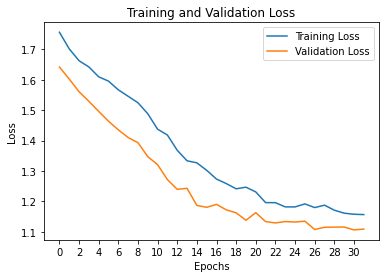

In [12]:
from matplotlib.pylab import plt
from numpy import arange


# Retrieve each dictionary's values
train_values = train_loss_dict.values()
val_values = val_loss_dict.values()

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(0, epochs)


# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs, 2))

# Display the plot
plt.legend(loc='best')
plt.show()